# Master Catalog
## A notebook to merge and do some catalog stats for all events in YP

In [1]:
import os
import sys
## This code block tells the notebook to find paths above it, 
# meaning modules above 'notebooks/' are now visible and can be imported.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
## subsequent imports    
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from plotconf import matsettings

Global variables.

In [2]:
# PDIR = "/uufs/chpc.utah.edu/common/home/koper-group2/jholt/Yellowstone/Local_Magnitude_Study/NonParaInvRedux"

# legacyCatPath = f"{PDIR}/catalogs/events/oldevids.yellowstone.cat"
# currentCatPath = f"{PDIR}/catalogs/events/newevids.yellowstone.cat"

CatPath = f"../catalogs/events/yellowstone.catalog.all.csv"

Functions

In [3]:
def extract_time_period_event_totals(df: pd.DataFrame, minDate: pd.Timestamp, maxDate: pd.Timestamp, freq: str = 'Y') -> np.array:
    """
    
    """
    
    py = pd.date_range(minDate, maxDate, freq=freq)

    totals = np.zeros(len(py)-1)
    for i, y in enumerate(py[:-1]):
        tmp_total = len(df[((df["DATE"]<=py[i+1])&(df["DATE"]>y))])
        totals[i] = tmp_total
        
    return totals

def plot_event_totals(totals: np.array, minDate: pd.Timestamp, maxDate: pd.Timestamp, freq: str = 'Y') -> None:
    """
    
    """
    mu = np.mean(totals)
    std = np.std(totals)
    
    py = pd.date_range(minDate, maxDate, freq=freq)
    py += pd.to_timedelta(52/2, 'W')  
    
    plt.step(py[:-1], totals, color='k')
#     plt.plot(py[:-1], totals, 'k')
    plt.hlines(mu, py[0], py[-2], color='r', linestyles='dashed', lw=2, label=f"annual mean: {int(np.rint(mu))}")
    plt.hlines(mu+std, py[0], py[-2], color='k', linestyles='dashed', lw=1, label=f"annual std dv: {int(np.rint(std))}")
    plt.hlines(mu-std, py[0], py[-2], color='k', linestyles='dashed', lw=1)
    plt.xlabel("Year")
    plt.ylabel("No. of Events")
    plt.legend()
    
    

    

In [4]:
# leg = pd.read_csv(legacyCatPath, delim_whitespace=True, skiprows=[1,])
# cur = pd.read_csv(currentCatPath, delim_whitespace=True, skiprows=[1,])
# total = pd.concat([leg, cur])
total = pd.read_csv(CatPath)

What is the catalog total?

In [5]:
totaleqs = len(total) ; totaleqs

47875

What is the total with at least one Magnitude value?
Dummy cells are assinged '-9.99' if there isn't an entry for either ML or MC (or both).
-9.99 - -9.99 = 0, therefore cells with 0 have neither an ML nor an MC.

In [6]:
total_quotable = total[(total.ML - total.MC) != 0]; len(total_quotable)

47167

What is the min, max ML or MC value for the catalog with at least one magnitude assignment per event.

In [7]:
ml = total_quotable[total_quotable.ML != -9.99].ML.min(), total_quotable.ML.max()
mc = total_quotable[total_quotable.ML != -9.99].ML.min(), total_quotable.ML.max()
np.min([ml, mc]), np.max([ml, mc])
print(f"{np.min(mc)} < MC < {np.max(mc)}")
print(f"{np.min(ml)} < Ml < {np.max(ml)}")

0.01 < MC < 4.83
0.01 < Ml < 4.83


What is the range of dates for said catalog?

In [8]:
mnd, mxd = total_quotable.DATE.min(), total_quotable.DATE.max()

Convert the 'Date' column to Timestamps so we can iterate through them meaninfully.

In [9]:
total["DATE"] = pd.to_datetime(total["DATE"])

What are the annual totals of events for all time?
Visualise and save the output. 
<br>
NOTE: We want to find a period where there is no apparent increase due to increased instrumentation coverage.

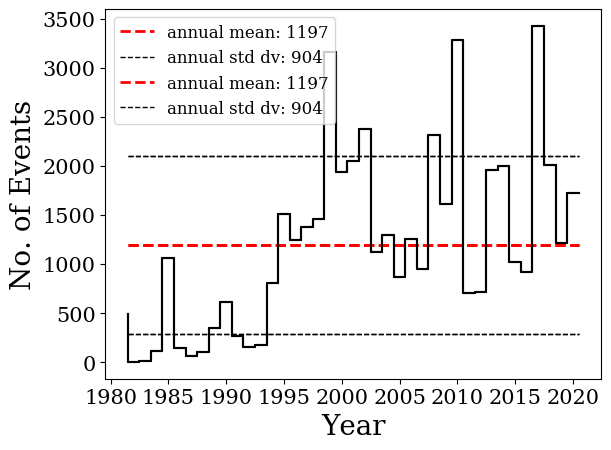

In [11]:
minDate = pd.to_datetime(mnd) # when using pd.date_range you have to start a year before for some reason.
maxDate = pd.to_datetime(mxd)
## numpy array containing yearly event totals - time period can be changed by freq, but no less than 1 day.
## 1 day is minimum because Date column is only informative to a given day (e.g. 2020/01/01).
totals = extract_time_period_event_totals(total, minDate, maxDate, freq="Y")
plot_event_totals(totals, minDate, maxDate, freq='Y')
plt.show()
plt.savefig(f"../figures/all-time-annual.pdf", transparent=True)

What are the annual totals of events between the start of 2000 and the end of 2019?
Visualise and save the output.

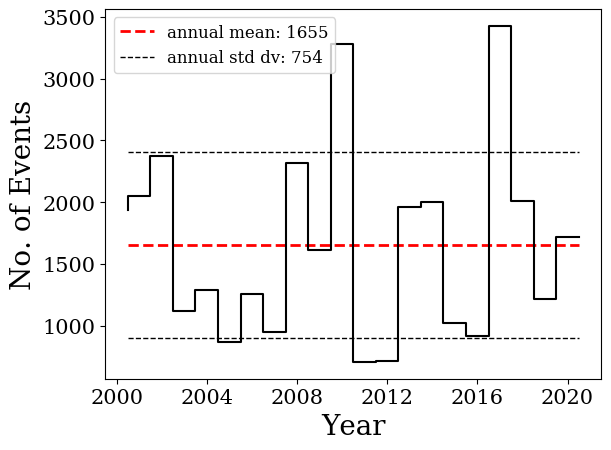

In [12]:
minDate = pd.to_datetime("1999-01-01") # when using pd.date_range you have to start a year before for some reason.
maxDate = pd.to_datetime(mxd)
## numpy array containing yearly event totals - time period can be changed by freq, but no less than 1 day.
## 1 day is minimum because Date column is only informative to a given day (e.g. 2020/01/01).
totals = extract_time_period_event_totals(total, minDate, maxDate, freq="Y")
# plt.close()
plot_event_totals(totals, minDate, maxDate, freq='Y')
plt.show()
plt.savefig(f"../figures/twenty-year-annual.pdf", transparent=True)

In [14]:
## subset events by those recorded only in 2019
minDate, maxDate = pd.to_datetime("2020-01-01"), ("2020-12-31")
twtyntn = total[((total["DATE"]<=maxDate)&(total["DATE"]>=minDate))]

In 2019, how many events were assinged an ML of the total that were recoreded?

In [17]:
withml = twtyntn[twtyntn.ML != -9.99]
no_all, no_w_ml = len(twtyntn), len(withml)
pct = no_w_ml/no_all * 100

print(f"In 2020, {no_w_ml} out of {no_all} events were assinged an ML.")
print(f"This equates to {pct:.2f}% of the catalog having an ML assigned in 2020.")

In 2020, 517 out of 1722 events were assinged an ML.
This equates to 30.02% of the catalog having an ML assigned in 2020.


And the same for MC.

In [18]:
withmc = twtyntn[twtyntn.MC != -9.99]

no_all, no_w_mc = len(twtyntn), len(withmc)
pct = no_w_mc/no_all * 100

print(f"In 2020, {no_w_mc} out of {no_all} events were assinged an MC.")
print(f"This equates to {pct:.2f}% of the catalog having an MC assigned in 2020.")

In 2020, 1686 out of 1722 events were assinged an MC.
This equates to 97.91% of the catalog having an MC assigned in 2020.


And how many with no magnitude assigned?

In [21]:
nomag = twtyntn[twtyntn.MC - twtyntn.ML == 0]

no_all, no_mag = len(twtyntn), len(nomag)
pct = no_mag/no_all * 100

print(f"In 2020, {no_mag} out of {no_all} events were not assigned at least one magntiude type.")
print(f"This equates to {pct:.2f}% of the catalog having neither an ML or an MC assinged in 2020.")

In 2020, 39 out of 1722 events were not assigned at least one magntiude type.
This equates to 2.26% of the catalog having neither an ML or an MC assinged in 2020.


And how many with both?

In [22]:
bothmag = twtyntn[(twtyntn.MC != -9.99) & (twtyntn.ML != -9.99)]
no_all, both_mag = len(twtyntn), len(bothmag)
pct = both_mag/no_all * 100

print(f"In 2020, {both_mag} out of {no_all} events were assinged an MC.")
print(f"This equates to {pct:.2f}% of the catalog having an ML and an MC assigned in 2020.")

In 2020, 514 out of 1722 events were assinged an MC.
This equates to 29.85% of the catalog having an ML and an MC assigned in 2020.


In [23]:
hasMC = total["MC"] != -9.99
hasML = total["ML"] != -9.99

tl = len(total) - len(total[(~hasMC & ~hasML)])

print(tl, len(total), tl/len(total)*100)

47263 47875 98.72167101827675


In [24]:
lmc = len(total[hasMC])
print(f"{lmc} out of {tl} with MC")
pct = (len(total[hasMC]) / len(total)) * 100
print(f"{pct:.1f} % with MC")

47145 out of 47263 with MC
98.5 % with MC


In [25]:
lml = len(total[hasML])
print(f"{lml} out of {tl} with MC")
pct = (len(total[hasML]) / len(total)) * 100
print(f"{pct:.1f} % with ML")

7999 out of 47263 with MC
16.7 % with ML
